This notebook walks through the creation of multitask models on MUV. The goal is to demonstrate that multitask methods outperform singletask methods on MUV.

In [1]:
%reload_ext autoreload
%autoreload 2
%pdb off
reload = True

Automatic pdb calling has been turned OFF


In [2]:
import os
import deepchem as dc


current_dir = os.path.dirname(os.path.realpath("__file__"))
dataset_file = "medium_muv.csv.gz"
full_dataset_file = "muv.csv.gz"

# We use a small version of MUV to make online rendering of notebooks easy. Replace with full_dataset_file
# In order to run the full version of this notebook
dc.utils.download_url("https://s3-us-west-1.amazonaws.com/deepchem.io/datasets/%s" % dataset_file,
                      current_dir)

dataset = dc.utils.save.load_from_disk(dataset_file)
print("Columns of dataset: %s" % str(dataset.columns.values))
print("Number of examples in dataset: %s" % str(dataset.shape[0]))

Columns of dataset: ['MUV-466' 'MUV-548' 'MUV-600' 'MUV-644' 'MUV-652' 'MUV-689' 'MUV-692'
 'MUV-712' 'MUV-713' 'MUV-733' 'MUV-737' 'MUV-810' 'MUV-832' 'MUV-846'
 'MUV-852' 'MUV-858' 'MUV-859' 'mol_id' 'smiles']
Number of examples in dataset: 10000


Now, let's visualize some compounds from our dataset

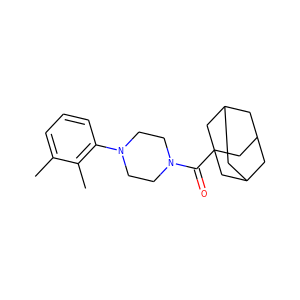

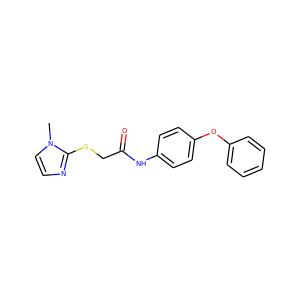

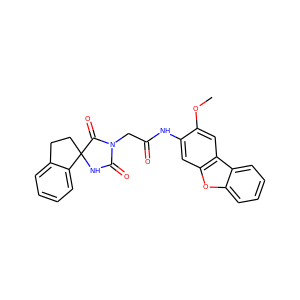

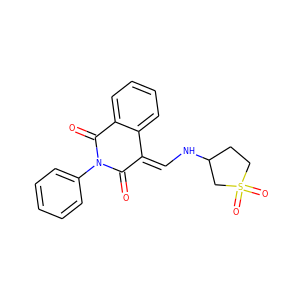

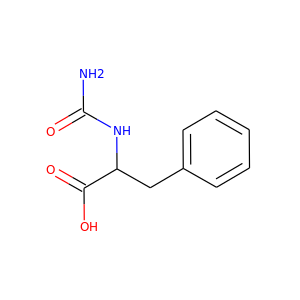

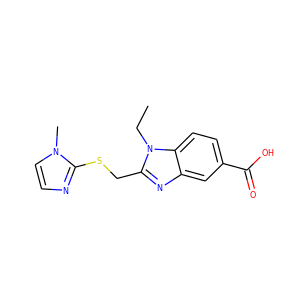

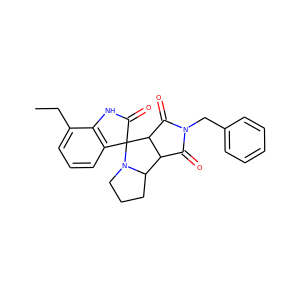

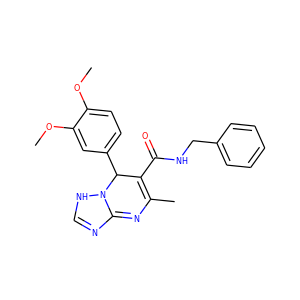

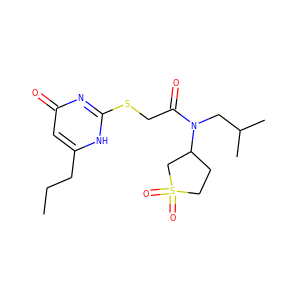

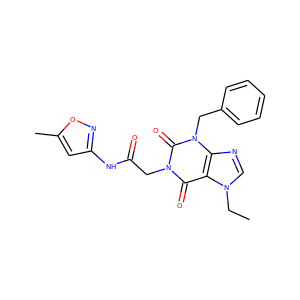

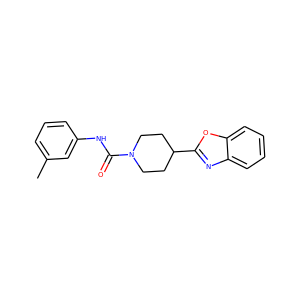

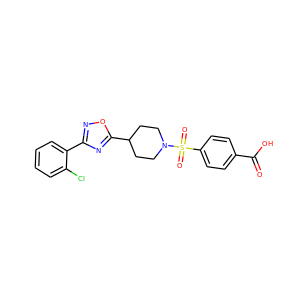

In [3]:
from rdkit import Chem
from rdkit.Chem import Draw
from itertools import islice
from IPython.display import Image, display, HTML

def display_images(filenames):
    """Helper to pretty-print images."""
    for filename in filenames:
        display(Image(filename))

def mols_to_pngs(mols, basename="test"):
    """Helper to write RDKit mols to png files."""
    filenames = []
    for i, mol in enumerate(mols):
        filename = "MUV_%s%d.png" % (basename, i)
        Draw.MolToFile(mol, filename)
        filenames.append(filename)
    return filenames

num_to_display = 12
molecules = []
for _, data in islice(dataset.iterrows(), num_to_display):
    molecules.append(Chem.MolFromSmiles(data["smiles"]))
display_images(mols_to_pngs(molecules))

In [4]:
MUV_tasks = ['MUV-692', 'MUV-689', 'MUV-846', 'MUV-859', 'MUV-644',
             'MUV-548', 'MUV-852', 'MUV-600', 'MUV-810', 'MUV-712',
             'MUV-737', 'MUV-858', 'MUV-713', 'MUV-733', 'MUV-652',
             'MUV-466', 'MUV-832']

featurizer = dc.feat.CircularFingerprint(size=1024)
loader = dc.data.CSVLoader(
      tasks=MUV_tasks, smiles_field="smiles",
      featurizer=featurizer)
dataset = loader.featurize(dataset_file)

Loading raw samples now.
shard_size: 8192
About to start loading CSV from medium_muv.csv.gz
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featurizing sample 8000
TIMING: featurizing shard 0 took 20.043 s
Loading shard 2 of size 8192.
Featurizing sample 0
Featurizing sample 1000
TIMING: featurizing shard 1 took 5.327 s
TIMING: dataset construction took 26.127 s
Loading dataset from disk.


In [5]:
splitter = dc.splits.RandomSplitter(dataset_file)
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
    dataset)
#NOTE THE RENAMING:
valid_dataset, test_dataset = test_dataset, valid_dataset

Computing train/valid/test indices
TIMING: dataset construction took 1.086 s
Loading dataset from disk.
TIMING: dataset construction took 0.628 s
Loading dataset from disk.
TIMING: dataset construction took 0.623 s
Loading dataset from disk.


In [6]:
import numpy as np
import numpy.random

params_dict = {"activation": ["relu"],
               "momentum": [.9],
               "batch_size": [50],
               "init": ["glorot_uniform"],
               "data_shape": [train_dataset.get_data_shape()],
               "learning_rate": [1e-3],
               "decay": [1e-6],
               "nb_epoch": [1],
               "nesterov": [False],
               "dropouts": [(.5,)],
               "nb_layers": [1],
               "batchnorm": [False],
               "layer_sizes": [(1000,)],
               "weight_init_stddevs": [(.1,)],
               "bias_init_consts": [(1.,)],
               "penalty": [0.], 
              } 


n_features = train_dataset.get_data_shape()[0]
def model_builder(model_params, model_dir):
  model = dc.models.TensorflowMultiTaskClassifier(
    len(MUV_tasks), n_features, **model_params)
  return model

metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean)
optimizer = dc.hyper.HyperparamOpt(model_builder)
best_dnn, best_hyperparams, all_results = optimizer.hyperparam_search(
    params_dict, train_dataset, valid_dataset, [], metric)

Fitting model 1/1
hyperparameters: {'learning_rate': 0.001, 'layer_sizes': (1000,), 'data_shape': (1024,), 'dropouts': (0.5,), 'activation': 'relu', 'decay': 1e-06, 'batch_size': 50, 'penalty': 0.0, 'nesterov': False, 'init': 'glorot_uniform', 'bias_init_consts': (1.0,), 'weight_init_stddevs': (0.1,), 'batchnorm': False, 'nb_layers': 1, 'nb_epoch': 1, 'momentum': 0.9}
Training for 1 epochs
On batch 0
On batch 50
On batch 100
On batch 150
Ending epoch 0: Average loss 0.0806059
On batch 0
TIMING: model fitting took 5.934 s True


/home/rbharath/deepchem/deepchem/metrics/__init__.py:297: UserWarning: Error calculating metric mean-roc_auc_score: Only one class present in y_true. ROC AUC score is not defined in that case.
  warnings.warn("Error calculating metric %s: %s" % (self.name, e))


computed_metrics: [nan, nan, nan, nan, 0.9719101123595506, nan, 0.53846153846153844, nan, 0.26206896551724135, 0.093167701863354019, nan, nan, nan, nan, nan, nan, nan]
Model 1/1, Metric mean-roc_auc_score, Validation set 0: 0.466402
	best_validation_score so far: 0.466402
computed_metrics: [0.98703633610900843, nan, 0.9991941982272361, 0.88525780682643429, 0.92781954887218054, 0.98714699493120928, 0.97551020408163269, 0.99670164917541237, 0.9819444444444444, 0.95366639806607578, 0.99887640449438209, 0.99217585692995525, nan, 0.99809451219512191, 0.99629355077835435, 1.0, 0.99847094801223246]
Best hyperparameters: (1e-06, (1024,), 1, 'relu', (1000,), 50, 0.0, False, 'glorot_uniform', (1.0,), (0.1,), 1, False, (0.5,), 0.001, 0.9)
train_score: 0.978546
validation_score: 0.466402
